In [1]:
import cv2
import numpy as np
import os
from tqdm import tqdm
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [52]:
def preprocess_video(video_path, show_nth_frame=4, target_size=(24, 24), max_frames=25):
    processed_video = []
    cap = cv2.VideoCapture(video_path)
    
    # Check the total frame count
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames <100 :
        # Skip videos with fewer than 120 frames
        print(f"Skipping video {video_path} due to insufficient frames: {total_frames}")
        cap.release()
        return None  # or an empty list, depending on your handling

    frame_counter = 0
    
    while cap.isOpened() and frame_counter < max_frames*show_nth_frame:
        ret, frame = cap.read()
        
        # Exit the loop if there are no more frames
        if not ret:
            break
        
        # Process every nth frame
        if frame_counter % show_nth_frame == 0:
            # Convert frame to grayscale and resize
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            res_frame = cv2.resize(gray_frame, target_size)
            norm_frame = res_frame.astype(np.float32) / 255.0
            processed_video.append(norm_frame)
        
        frame_counter += 1  # Increment the total frame counter regardless of processing
        
    cap.release()
    return np.array(processed_video)

In [53]:
home = 'E:\jupyter notebook\Computer Vision\Activity Recogntion\Activity Data\Human Activity Recognition - Video Dataset'
classes = os.listdir(home)  # Get the list of activity classes

Videos = []  # To store processed video data
Activity = []  # To store corresponding labels
# Loop over each class and process the video files
for cls in classes:
    sub_cls_path = os.path.join(home, cls)  # Path to the folder of a specific activity
    video_files = os.listdir(sub_cls_path)  # Get all video files in the activity class

    for file in tqdm(video_files, desc=f"Processing {cls}"):
        file_path = os.path.join(sub_cls_path, file)  # Full path to the video file
        
        # Process the video using your function
        ved = preprocess_video(file_path)
        
        Activity.append(cls)  # Append the activity label
        Videos.append(ved)    # Append the processed video frames

print(f"Processed {len(Videos)} videos from {len(classes)} activity classes.")

Processing Walking While Using Phone: 100%|██████████| 143/143 [01:10<00:00,  2.03it/s]

Processed 1113 videos from 7 activity classes.


In [55]:
# Convert Videos and Activity to numpy arrays for model input
Videos = np.array(Videos)  # Shape: (num_samples, 22, 224, 224, 3)
Activity = np.array(Activity)  # Shape: (num_samples,)

print(f"Shape of processed video data: {Videos.shape}")
print(f"Number of activity labels: {len(Activity)}")


Shape of processed video data: (1113, 25, 24, 24)
Number of activity labels: 1113


In [57]:
Activity

array(['Clapping', 'Clapping', 'Clapping', ...,
       'Walking While Using Phone', 'Walking While Using Phone',
       'Walking While Using Phone'], dtype='<U26')

In [56]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode activity labels into integers
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(Activity)

# Convert the integer encoded labels to one-hot encoded labels
one_hot_labels = to_categorical(integer_encoded)

print(f"Original Labels: {Activity[:7]}")
print(f"Encoded Labels: {integer_encoded[:7]}")
print(f"One-hot Encoded Labels:\n {one_hot_labels[:7]}")

Original Labels: ['Clapping' 'Clapping' 'Clapping' 'Clapping' 'Clapping' 'Clapping'
 'Clapping']
Encoded Labels: [0 0 0 0 0 0 0]
One-hot Encoded Labels:
 [[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


In [58]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Videos, one_hot_labels, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (890, 25, 24, 24)
Testing data shape: (223, 25, 24, 24)


In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed, Dropout

# Define the CNN + LSTM model
def build_cnn_lstm_model(input_shape, num_classes):
    model = Sequential()

    # TimeDistributed wrapper for CNN to apply CNN on each frame
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))

    model.add(TimeDistributed(Flatten()))  # Flatten each frame

    # LSTM layer for temporal sequence processing
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.5))

    # Output layer with softmax for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Define input shape
time_steps = 25  # Number of frames in the sequence
frame_height, frame_width = 24, 24  # Frame dimensions after preprocessing
channels = 1  # Use 1 for grayscale or 3 for RGB
input_shape = (time_steps, frame_height, frame_width, channels)

# Define number of classes
num_classes = 7  # Replace this with actual number of classes in your label encoder

# Build and compile the model
model = build_cnn_lstm_model(input_shape, num_classes)

# Display model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ (None, 25, 24, 24, 32) │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 25, 12, 12, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 25, 12, 12, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 25, 12, 12, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 25, 6, 6, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 25, 6, 6, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 25, 2304)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │     1,245,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,265,415 (4.83 MB)

 Trainable params: 1,265,415 (4.83 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
history = model.fit(X_train, y_train, 
                    validation_split=0.2,  # 20% of training data used for validation
                    epochs=20, 
                    batch_size=8)

# Save the trained model
model.save('activity_recognition_model.h5')

Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 0.1663 - loss: 2.0081 - val_accuracy: 0.2528 - val_loss: 1.8147
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 0.3279 - loss: 1.6368 - val_accuracy: 0.5506 - val_loss: 1.1529
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 0.6409 - loss: 0.9736 - val_accuracy: 0.7135 - val_loss: 0.8583
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 0.7831 - loss: 0.6575 - val_accuracy: 0.7303 - val_loss: 0.6580
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 0.8414 - loss: 0.4911 - val_accuracy: 0.8146 - val_loss: 0.5110
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 0.8936 - loss: 0.2828 - val_accuracy: 0.8371 - val_loss: 0.4891
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 0.9001 - loss: 0.2960 - val_accuracy: 0.8034 - val_loss: 0.5670
Epoch 8/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 0.9420 - loss: 0.2068 - val_accu

In [65]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9741 - loss: 0.0982
Test Loss: 0.13253754377365112
Test Accuracy: 0.9686098694801331


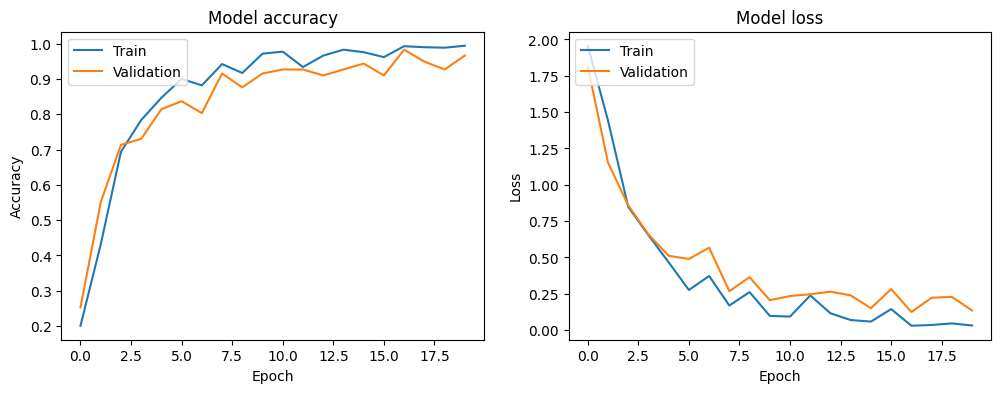

In [66]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [69]:
# Predict on test data
predictions = model.predict(X_test)

# Convert predictions from one-hot encoded to label
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Print the classification report
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes, target_names=label_encoder.classes_))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
                            precision    recall  f1-score   support

                  Clapping       0.97      0.97      0.97        34
            Meet and Split       0.93      0.96      0.94        26
                   Sitting       0.93      1.00      0.97        28
            Standing Still       1.00      0.95      0.98        42
                   Walking       0.93      0.93      0.93        28
Walking While Reading Book       1.00      0.97      0.98        33
 Walking While Using Phone       1.00      1.00      1.00        32

                  accuracy                           0.97       223
                 macro avg       0.97      0.97      0.97       223
              weighted avg       0.97      0.97      0.97       223



# Testing random video

In [89]:
pth="E:\jupyter notebook\Computer Vision\Activity Recogntion\Activity Data\Human Activity Recognition - Video Dataset\Walking\Walking (39).mp4"
def predict_activity(path):
    # Process the video using your function
    input=preprocess_video(pth)
    input_array=np.array(input)
    reshaped_input_array=np.reshape(input_array,(1,25,24,24))
    pdt=model.predict(reshaped_input_array)
    Label=label_encoder.inverse_transform(np.argmax(pdt,axis=1))[0]
    return Label
predict_activity(pth)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


'Walking'

In [84]:
# save the model 
# model.save("activity_recognition_model.h5")

In [91]:
predict_activity("E:\jupyter notebook\Computer Vision\Activity Recogntion\Activity Data\Human Activity Recognition - Video Dataset\Walking\Walking (9).mp4")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


'Walking'